<a href="https://colab.research.google.com/github/gauravlochab/notebooks/blob/main/legal_text_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Please go through the below assignment .

# Problem statement: Build a classification model to classify the legal text as per the classes in the column 'case_outcome'.
# Also, perform Exploratory Data Analysis (EDA) and pre-processing steps before Model training.
# The models should include traditional Machine Learning based models (like regression or tree-based) and language-based models like deep neural networks.
# Provide your analysis on which model should be deployed in Production.

# Contents


### Data Concat , Data Pre-processing, Data Sampling, EDA , Data Features, Embedding, Modeling - Logistic Regression , one more model, LSTM(keras), Huggingface (Legal text)     


Importing libraries and the Dataset
requirements.txt
NTLK
PLOTLY
TEXTBLOB
WORDCLOUD



In [5]:
import nltk
nltk.download('stopwords')
import numpy as np 
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "plotly_white"
import os
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import plotly.express as px
import re
import string
from nltk.stem import WordNetLemmatizer
string.punctuation
from nltk.corpus import stopwords
stop = stopwords.words('english')
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from nltk.tokenize import word_tokenize
from nltk import pos_tag


import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df=pd.read_csv("/content/drive/MyDrive/text classification.csv")
df.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [8]:
df['case_title'] = df['case_title'].astype('str') 
df['case_text'] = df['case_text'].astype('str') 

In [9]:
df.count()

case_id         24985
case_outcome    24985
case_title      24985
case_text       24985
dtype: int64

In [10]:
df['case_title'].nunique()

18581

### Data Processing and Cleaning

- Filtering for text columns
- Merge all text attributes (case title, case text description) into one attribute
- Removing NaNs
- Dropping Duplicates
- Label encoder from text to numbers for 10 classes 
- Removal of punctuations
- Standardizing the text case as lower
- Removing digits from the text


In [11]:
#merging columns
df['case_text_merged'] = (df['case_title'].map(str) +' '+ df['case_text']).apply(lambda row: row.strip())
df1 = df[['case_outcome', 'case_text_merged']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['case_text_merged'])]


In [12]:
df1['category_id'] = df1['case_outcome'].factorize()[0]
category_id_df = df1[['case_outcome', 'category_id']].drop_duplicates()


category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'case_outcome']].values)

df1.head()

,case_outcome,case_text_merged,category_id
0,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,0
1,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,0
2,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,0
3,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,0
4,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,0


In [13]:
category_id_df

,case_outcome,category_id
0,cited,0
8,applied,1
9,followed,2
18,referred to,3
25,related,4
34,considered,5
49,discussed,6
114,distinguished,7
184,affirmed,8
1057,approved,9


In [14]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df1['case_text_merged']= df1['case_text_merged'].apply(lambda x:remove_punctuation(x))
# lower case
df1['case_text_merged']= df1['case_text_merged'].apply(lambda x: x.lower())
df1['case_text_merged']= df1['case_text_merged'].str.replace('\d+', '')
#Removing Stop Words
df1['case_text_merged']=df1['case_text_merged']
df1['case_text_merged'] = df1['case_text_merged'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [15]:
id_to_category

{0: 'cited',
 1: 'applied',
 2: 'followed',
 3: 'referred to',
 4: 'related',
 5: 'considered',
 6: 'discussed',
 7: 'distinguished',
 8: 'affirmed',
 9: 'approved'}

In [16]:
df1.head()

,case_outcome,case_text_merged,category_id
0,cited,alpine hardwood aust pty ltd v hardys pty ltd ...,0
1,cited,black v lipovac fca alr general principles gov...,0
2,cited,colgate palmolive co v cussons pty ltd fcr ord...,0
3,cited,dais studio pty ltd v bullett creative pty ltd...,0
4,cited,dr martens australia pty ltd v figgins holding...,0


### Adding extra features from the text
* word length
* character length
* subjectivity score
* word density 
* polarity score



* word density :  ratio of char to the word

* subjectivity : Objective statements refer to factual information, whereas subjective sentences typically allude to personal opinion or emotion. Subjectivity is a float with a range of [0, 1], with higher values representing greater subjectivity

* The polarity score, which ranges from -1 to +1, indicates the tone of a particular text; a score of -1 indicates that the text has a strongly negative undertone. Similar to how +1 indicates a sentence's strongly positive undertone and 0 indicates neutral text

In [17]:
#Adding features character length,density word length and Polarity score for each record
df1['Character_length']= df1['case_text_merged'].str.len()
df1['Word_length']=df1['case_text_merged'].str.count(' ') + 1
df1['Word_density']=df1['Character_length'] / df1['Word_length']
def sentiment_func(text):
    return TextBlob(text).sentiment[0]

def sub_func(text):
    return TextBlob(text).sentiment[1]
    
df1['Polarity_score']=df1.case_text_merged.apply(lambda x: sentiment_func(x))
df1['Subjectivity_score']=df1.case_text_merged.apply(lambda x: sub_func(x))

In [18]:
df1.head()

,case_outcome,case_text_merged,category_id,Character_length,Word_length,Word_density,Polarity_score,Subjectivity_score
0,cited,alpine hardwood aust pty ltd v hardys pty ltd ...,0,342,56,6.107143,0.114286,0.680357
1,cited,black v lipovac fca alr general principles gov...,0,629,87,7.229885,0.066667,0.588095
2,cited,colgate palmolive co v cussons pty ltd fcr ord...,0,331,53,6.245283,0.114286,0.680357
3,cited,dais studio pty ltd v bullett creative pty ltd...,0,656,92,7.130435,0.161905,0.669048
4,cited,dr martens australia pty ltd v figgins holding...,0,553,78,7.089744,-0.010000,0.400000


 ###  Analyse the relationship across number of words and the case results

In [19]:
df_word=df1.groupby(['case_outcome'],as_index=False).agg({'Word_length':'mean'}).rename(columns={'Word_length': 'Average Word Length'}).sort_values(by='Average Word Length',ascending=False).reset_index(drop=True)
fig = px.bar(df_word, x="case_outcome",y="Average Word Length",color='case_outcome',
             height=450)
fig.update_traces(textposition='outside')
fig.update_layout(width=800,height=600,
    title={
        'text': "Average number of words across case outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()


## Top 20 Words Across Case

In [20]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df1['case_text_merged'], 20)


    
df_unigram_20 = pd.DataFrame(common_words, columns = ['Word' , 'count']).sort_values(by="count",ascending=False).reset_index(drop=True)

fig = px.bar(df_unigram_20, x='Word', y='count')
fig.update_layout(
    title={
        'text': "Top 20 words across all cases",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### Bar distribution of target varibale (text outcome)

Text(0.5, 0, 'Number of ocurrences')

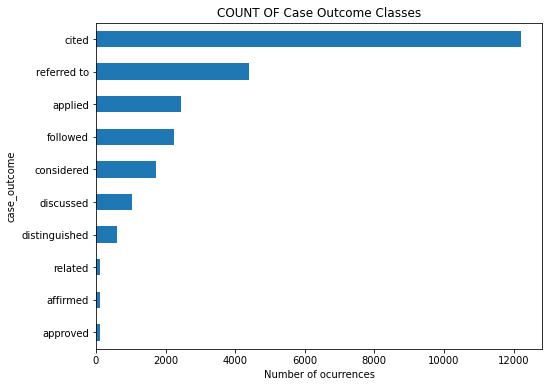

In [21]:
fig = plt.figure(figsize=(8,6))

df1.groupby('case_outcome').case_text_merged.count().sort_values().plot.barh(ylim=0, title= 'COUNT OF Case Outcome Classes')
plt.xlabel('Number of ocurrences', fontsize = 10)


### Random sampling 
##### It turned out that algorithms used cause memory overload if trained on the whole dataset. For this reason, a random sample is taken out to train the models on less entries.

In [22]:
df2 = df1.sample(5000, random_state=1).copy()

#### A brief check shows the sampled data have similar distribution of case outcomes.

Text(0.5, 0, 'Number of ocurrences')

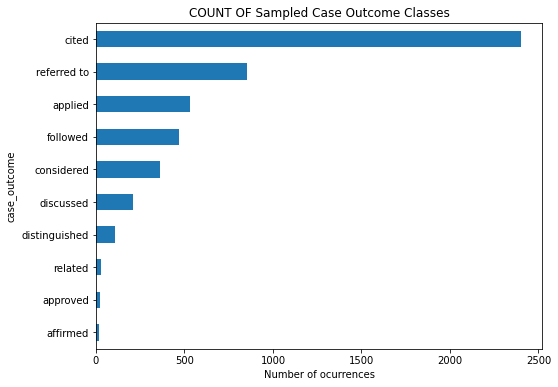

In [23]:
fig = plt.figure(figsize=(8,6))

df2.groupby('case_outcome').case_text_merged.count().sort_values().plot.barh(ylim=0, title= 'COUNT OF Sampled Case Outcome Classes')
plt.xlabel('Number of ocurrences', fontsize = 10)


In [24]:
df2.head()

,case_outcome,case_text_merged,category_id,Character_length,Word_length,Word_density,Polarity_score,Subjectivity_score
17536,applied,castlemaine tooheys ltd v south australia hca ...,1,850,114,7.456140,0.020068,0.422279
4641,cited,florgale uniforms pty ltd v orders vsc vr whil...,0,753,102,7.382353,-0.029167,0.294444
16691,cited,lansen v minister environment heritage fcafc f...,0,1900,248,7.661290,0.092392,0.467876
17732,cited,cardile v led builders pty ltd hca clr indicat...,0,749,113,6.628319,-0.024074,0.398148
18443,cited,goldberg v morrow fca decision judge adjourn h...,0,964,127,7.590551,-0.060073,0.514652


In [25]:
#removing case_outcome column as we have done the analysis
df2 = df2.drop(['case_outcome'], axis=1)

## Splitting the data into test and train

In [26]:
from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df2, random_state=42,stratify=df2['category_id'])


In [27]:
df_train

,case_text_merged,category_id,Character_length,Word_length,Word_density,Polarity_score,Subjectivity_score
21227,state queensland v pioneer concrete qld pty lt...,0,1361,179,7.603352,0.062963,0.416204
10084,mcdonalds systems australia pty ltd v mcwillia...,5,2163,280,7.725000,-0.040686,0.452374
6674,mackenzie v childers ch supports argument agre...,0,833,102,8.166667,-0.120000,0.400000
23963,bhagat v global custodians ltd fcafc would how...,0,583,84,6.940476,0.125000,0.166667
9157,allstate life insurance co v anz banking group...,3,878,131,6.702290,0.025812,0.484253
...,...,...,...,...,...,...,...
5065,popovic v tanasijevic sasc secondly respondent...,0,2704,343,7.883382,0.107202,0.419762
18597,constantine v trade practices commissioner fcr...,3,3473,412,8.429612,0.101203,0.362386
11697,mann v abruzzi sports club ltd acsr principles...,3,581,76,7.644737,0.125714,0.288571
15567,microsoft corporation v pc club australia pty ...,0,593,81,7.320988,0.091402,0.362566


## Extracting out the structured features from previous experiments

In [28]:
df_train_metadata = df_train.drop(['case_text_merged'], axis=1).reset_index(drop=True)
df_test_metadata = df_test.drop(['case_text_merged'], axis=1).reset_index(drop=True)

df_train_metadata.head()

,category_id,Character_length,Word_length,Word_density,Polarity_score,Subjectivity_score
0,0,1361,179,7.603352,0.062963,0.416204
1,5,2163,280,7.725000,-0.040686,0.452374
2,0,833,102,8.166667,-0.120000,0.400000
3,0,583,84,6.940476,0.125000,0.166667
4,3,878,131,6.702290,0.025812,0.484253


## vectorization

#### Adding Bag of Words based Features - 1-grams

This is perhaps the most simple vector space representational model for unstructured text. A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values.

The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.



In [29]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))
df_traincv = cv.fit_transform(df_train['case_text_merged']).toarray()
df_traincv = pd.DataFrame(df_traincv, columns=cv.get_feature_names())

df_testcv = cv.transform(df_test['case_text_merged']).toarray()
df_testcv = pd.DataFrame(df_testcv, columns=cv.get_feature_names())
df_traincv.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,aaa,aaad,aab,aac,aaco,aacos,aad,aadb,aafc,...,zwier,zwiers,zy,zyfert,zz,zzk,zzkb,zzkbi,zzo,zzob
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_train_comb = pd.concat([df_train_metadata, df_traincv], axis=1)
df_test_comb = pd.concat([df_test_metadata, df_testcv], axis=1)

df_train_comb.head()

,category_id,Character_length,Word_length,Word_density,Polarity_score,Subjectivity_score,aa,aaa,aaad,aab,...,zwier,zwiers,zy,zyfert,zz,zzk,zzkb,zzkbi,zzo,zzob
0,0,1361,179,7.603352,0.062963,0.416204,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,2163,280,7.725000,-0.040686,0.452374,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,833,102,8.166667,-0.120000,0.400000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,583,84,6.940476,0.125000,0.166667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,878,131,6.702290,0.025812,0.484253,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Training a Logistic Regression Model

### A logistic regression model is easy to train, interpret and works well on a wide variety of NLP problems

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1, random_state=42, solver='liblinear')

In [32]:
lr.fit(df_train_comb.drop(['category_id'],axis =1), df_train_comb['category_id'])
predictions = lr.predict(df_test_comb.drop(['category_id'],axis =1))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [33]:
from sklearn.metrics import confusion_matrix, classification_report


In [34]:
print(classification_report(df_test_comb['category_id'], predictions))


              precision    recall  f1-score   support

           0       0.57      0.81      0.67       601
           1       0.31      0.22      0.26       133
           2       0.27      0.10      0.15       117
           3       0.44      0.35      0.39       213
           4       0.60      0.38      0.46         8
           5       0.28      0.14      0.19        90
           6       0.29      0.10      0.14        52
           7       0.25      0.08      0.12        26
           8       0.20      0.20      0.20         5
           9       0.00      0.00      0.00         5

    accuracy                           0.50      1250
   macro avg       0.32      0.24      0.26      1250
weighted avg       0.45      0.50      0.45      1250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



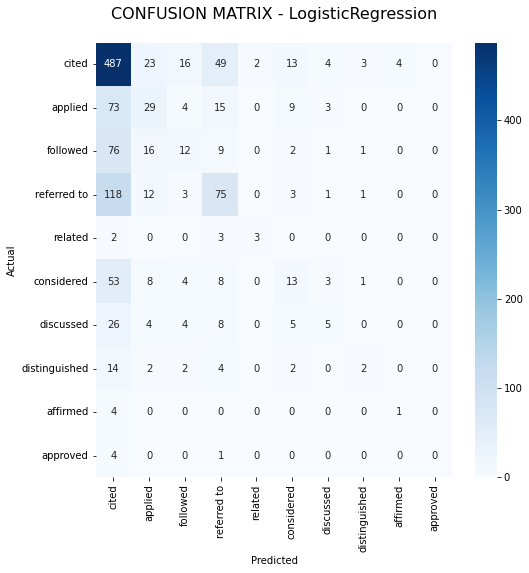

In [35]:
import seaborn as sns
conf_mat = confusion_matrix(df_test_comb['category_id'], predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.case_outcome.values, 
            yticklabels=category_id_df.case_outcome.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

In [36]:
## using LSTM for doing the text classification

In [37]:
df2

,case_text_merged,category_id,Character_length,Word_length,Word_density,Polarity_score,Subjectivity_score
17536,castlemaine tooheys ltd v south australia hca ...,1,850,114,7.456140,0.020068,0.422279
4641,florgale uniforms pty ltd v orders vsc vr whil...,0,753,102,7.382353,-0.029167,0.294444
16691,lansen v minister environment heritage fcafc f...,0,1900,248,7.661290,0.092392,0.467876
17732,cardile v led builders pty ltd hca clr indicat...,0,749,113,6.628319,-0.024074,0.398148
18443,goldberg v morrow fca decision judge adjourn h...,0,964,127,7.590551,-0.060073,0.514652
...,...,...,...,...,...,...,...
9705,minister immigration ethnic affairs v pochi fc...,0,1229,156,7.878205,0.309091,0.593939
9485,deputy commissioner taxation v richard walter ...,0,2179,286,7.618881,0.103000,0.442000
20092,philip morris inc v adam p brown male fashions...,1,1084,149,7.275168,0.086667,0.286667
16286,green v housing authority clackamas county f s...,0,1235,164,7.530488,0.012443,0.492149


In [38]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df2['case_text_merged'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 27071 unique tokens.


In [39]:
X = tokenizer.texts_to_sequences(df2['case_text_merged'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5000, 250)


In [40]:
Y = pd.get_dummies(df2['category_id']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5000, 10)


In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4500, 250) (4500, 10)
(500, 250) (500, 10)


In [42]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
epochs = 1
batch_size = 16

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

254/254 [==============================] - 278s 1s/step - loss: 1.6446 - accuracy: 0.4748 - val_loss: 1.5205 - val_accuracy: 0.5267


In [44]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16/16 [==============================] - 1s 64ms/step - loss: 1.6594 - accuracy: 0.4600
Test set
  Loss: 1.659
  Accuracy: 0.460


In [45]:
Y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [46]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

8/8 [==============================] - 1s 64ms/step


In [47]:
rounded_labels=np.argmax(Y_test, axis=1)

In [48]:
print(classification_report(rounded_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63       230
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        42
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        26
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2

    accuracy                           0.46       500
   macro avg       0.05      0.10      0.06       500
weighted avg       0.21      0.46      0.29       500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Using Tranformers

In [49]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 7.1 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 115 kB 57.0 MB/s 
     |████████████████████████████████| 163 kB 73.6 MB/s 
     |████████████████████████████████| 212 kB 63.9 MB/s 
     |████████████████████████████████| 127 kB 64.9 MB/s 
     |████████████████████████████████| 115 kB 67.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [50]:
 
##packages transformers,datasets 
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict

In [51]:
df_train.rename(columns = {'case_text_merged':'text','category_id':'label'}, inplace = True)
df_test.rename(columns = {'case_text_merged':'text','category_id':'label'}, inplace = True)

In [52]:
df_train_new = df_train[['label','text']]
df_test_new = df_test[['label','text']]
df_train_new.reset_index(inplace=True)
df_test_new.reset_index(inplace=True)
train_ds = Dataset.from_pandas(df_train_new[['label','text']])
valid_ds = Dataset.from_pandas(df_test_new[['label','text']])
 


ds = DatasetDict()

ds['train'] = train_ds
ds['validation'] = valid_ds

print(ds)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3750
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1250
    })
})


In [57]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 7.7 MB/s 
     |████████████████████████████████| 7.6 MB 52.9 MB/s 


In [58]:
# hide_output
from transformers import AutoTokenizer
#nlpaueb/legal-bert-small-uncased
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [59]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [60]:
# hide_output
legal_encoded = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
print(legal_encoded["train"].column_names)

['label', 'text', 'input_ids', 'attention_mask']


In [62]:
# hide_output
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    

In [64]:
from transformers import AutoModelForSequenceClassification

num_labels = 10
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [65]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [66]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(legal_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #push_to_hub=True, 
                                  log_level="error")

In [67]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=legal_encoded["train"],
                  eval_dataset=legal_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.639300,1.558728,0.480800,0.312221
2,1.564900,1.538792,0.480800,0.312221
3,1.523200,1.527903,0.482400,0.321193


In [68]:
preds_output = trainer.predict(legal_encoded["validation"])

In [69]:
preds_output.metrics

{'test_loss': 1.5279027223587036,
 'test_accuracy': 0.4824,
 'test_f1': 0.32119262773154994,
 'test_runtime': 22.202,
 'test_samples_per_second': 56.301,
 'test_steps_per_second': 3.558}

In [70]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

### NLP models used/can be used
- we have covered the whole journey of NLP starting with BOW to LSTM to transfomers
- we could have used methods like tfidf to scale down the reccuring word in the all the coprus 
- we could have used word2vec embedding to find out embedding using NN
- we can LSTM for training that can be used for longer seuqences like we have in data
- we used bert for text classification

## For production we should choose?

### Chosing LLM like bert 
- they take in account the complex context relation like we have in that text using self attention mechanism 
- if we want to train our model in live production env to improve them to learn with the changing distribution  
- an ability to process larger amounts of text and language.
- an easy route to using pre-trained models (transfer learning)

### Choosing model like logistic regression or gradient boosted tree
- easy to train and way less params 
- when there is a resource crunch 'cause heavy resources required not required in the data 
- no online training required 

## What can be done after these baselines
- we have a lot of imbalance in data to across the classes we ca undersample data in major classes and oversample the data in minor class
- weighing the loss function so that it penalizes more when the ground truth belongs to the minority class
- tuning of hyperparatmeters using hyper opt or finding best params using grid search or random search 

